In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

In [2]:
df_matches=pd.read_csv('D:/ign/ign_bracket_competition.csv')
df_contester=pd.read_csv('D:/ign/ign_contesters.csv')

In [3]:
#改变元素类型
lst1=df_matches['Game'].to_list()
lst2=df_matches['Opponent'].to_list()

s_competition=list(set(lst1+lst2)) 

In [4]:
#找出两张表中，名字不对应的行
df_contester[~df_contester['Name'].isin(s_competition)]

,Name,Genre,Publisher,Developer,MultiPlayer,Free_To_Play,Versions,ESRB_Rating,Year,Critic_Score,User_Score,Total_Sold
15,Fable II,Role-Playing,Microsoft Game Studios,Lionhead Studios,True,False,2,3,2008,8.9,6.600000,3.50
17,Final Fantasy VII,Role-Playing,Sony,SquareSoft,False,False,8,2,1997,9.2,9.200000,11.04
36,Persona 5,Role-Playing,Atlus,Atlus,False,False,2,3,2017,9.3,8.700000,2.10
37,Pokemon Red / Green / Blue Version,Role-Playing,Nintendo,Game Freak,False,False,1,1,1998,9.4,8.170889,31.38
61,Tony Hawk's Pro Skater 2,Sports,Activision/Blizzard,Neversoft Entertainment,True,False,6,2,2000,9.3,7.520000,6.85


In [5]:
#把名称统一
df_matches = df_matches.replace({'Fable 2':'Fable II',
                    'Final Fantasy VII (1997)': 'Final Fantasy VII',
                    'Persona 5 Royal': 'Persona 5',
                    'Pokemon Yellow': 'Pokemon Red / Green / Blue Version',
                    'Tony Hawk Pro Skater 2': "Tony Hawk's Pro Skater 2"})

lst1=df_matches['Game'].to_list()
lst2=df_matches['Opponent'].to_list()

s_competition=list(set(lst1+lst2))
df_contester[~df_contester['Name'].isin(s_competition)]

,Name,Genre,Publisher,Developer,MultiPlayer,Free_To_Play,Versions,ESRB_Rating,Year,Critic_Score,User_Score,Total_Sold


In [6]:
#统计出相同发行商，类型，开发商的数量
publi_game=df_contester['Publisher'].value_counts().reset_index().rename(columns={'index':'Publisher', 'Publisher':'Pub. Freq.'})
genre_game=df_contester['Genre'].value_counts().reset_index().rename(columns={'index':'Genre', 'Genre':'Genre Freq.'})
dev_game=df_contester['Developer'].value_counts().reset_index().rename(columns={'index':'Developer', 'Developer':'Dev. Freq.'})

df_contester=pd.merge(df_contester, publi_game, how='left', on='Publisher')
df_contester=pd.merge(df_contester, genre_game, how='left', on='Genre')
df_contester=pd.merge(df_contester, dev_game, how='left', on='Developer')

In [7]:
df_contester

,Name,Genre,Publisher,Developer,MultiPlayer,Free_To_Play,Versions,ESRB_Rating,Year,Critic_Score,User_Score,Total_Sold,Pub. Freq.,Genre Freq.,Dev. Freq.
0,Animal Crossing: New Horizons,Misc,Nintendo,Nintendo,True,False,1,1,2020,9.000000,5.500000,33.86,13,3,8
1,Apex Legends,Shooter,Electronic Arts,Respawn Entertainment,True,True,3,2,2019,8.900000,6.900000,0.00,5,13,2
2,Assassin's Creed IV: Black Flag,Action/Adventure,Ubisoft,Ubisoft Montreal,True,False,6,3,2013,8.540000,7.900000,15.44,1,6,1
3,Batman: Arkham City,Action,Warner,Rocksteady Studios,False,False,3,2,2011,9.366667,8.700000,14.02,2,11,1
4,BioShock,Shooter,2K Games,Irrational Games,False,False,5,3,2007,9.533333,8.733333,6.05,3,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,The Witcher 3: Wild Hunt,Role-Playing,Warner,CD Projekt Red Studio,False,False,3,3,2015,9.200000,9.266667,13.57,2,14,1
60,Titanfall 2,Shooter,Electronic Arts,Respawn Entertainment,True,False,3,3,2016,8.733333,8.333333,3.71,5,13,2
61,Tony Hawk's Pro Skater 2,Sports,Activision/Blizzard,Neversoft Entertainment,True,False,6,2,2000,9.300000,7.520000,6.85,7,1,1
62,Uncharted 2: Among Thieves,Action,Sony,Naughty Dog,False,False,1,2,2009,9.600000,8.900000,7.76,7,11,2


In [8]:
#将game和opponent一一对应，合成一张表
df_num=df_contester[['Name', 'MultiPlayer', 'Free_To_Play',  'Versions', 'ESRB_Rating','Year','Critic_Score', 'User_Score',
                       'Total_Sold', 'Pub. Freq.', 'Genre Freq.','Dev. Freq.']].copy()

num_game=df_num.rename(columns={'Name':'Game'})
num_op=df_num.rename(columns={'Name':'Opponent'})

df_matches=pd.merge(df_matches,num_game,how='left',on='Game')
df_matches=pd.merge(df_matches,num_op,how='left',on='Opponent',suffixes=(' Game', ' Op.'))

In [9]:
#处理特征，将其合并
df_old = df_matches.copy()

df_matches['TS/Version Game']=df_matches['Total_Sold Game']/df_matches['Versions Game']
df_matches['TS/Version Op.']=df_matches['Total_Sold Op.']/df_matches['Versions Op.']

df_matches.drop(['Total_Sold Game', 'Versions Game', 'Total_Sold Op.', 'Versions Op.'], axis=1, inplace=True)

In [10]:
df_matches['Year Dif.'] = df_matches['Year Game'] - df_matches['Year Op.']
df_matches['Rating Dif.'] = df_matches['ESRB_Rating Game'] - df_matches['ESRB_Rating Op.']
df_matches['CS Dif.'] = df_matches['Critic_Score Game'] - df_matches['Critic_Score Op.']
df_matches['US Dif.'] = df_matches['User_Score Game'] - df_matches['User_Score Op.']
df_matches['TS/Version Dif.'] = df_matches['TS/Version Game'] - df_matches['TS/Version Op.']
df_matches['Multi Dif.'] = df_matches['MultiPlayer Game'].astype(int) - df_matches['MultiPlayer Op.'].astype(int)

df_matches.drop(['Year Game', 'Year Op.', 'ESRB_Rating Game', 'ESRB_Rating Op.',
                 'MultiPlayer Game','MultiPlayer Op.', 'Critic_Score Game', 'Critic_Score Op.',
                 'User_Score Game', 'User_Score Op.', 'Free_To_Play Game', 'Free_To_Play Op.'],
                axis=1, inplace=True)

In [11]:
df_matches['Dev. Freq. Ratio'] = df_matches['Dev. Freq. Game'] / df_matches['Dev. Freq. Op.']
df_matches['Genre Freq. Ratio'] = df_matches['Genre Freq. Game'] / df_matches['Genre Freq. Op.']
df_matches['Pub. Freq. Ratio'] = df_matches['Pub. Freq. Game'] / df_matches['Pub. Freq. Op.']

df_matches.drop(['TS/Version Game', 'TS/Version Op.', 'Dev. Freq. Game', 'Dev. Freq. Op.',
                 'Genre Freq. Game', 'Genre Freq. Op.', 'Pub. Freq. Game', 'Pub. Freq. Op.'], axis=1, inplace=True)

In [12]:
df_matches

,Game,Opponent,Ratio,Win,Year Dif.,Rating Dif.,CS Dif.,US Dif.,TS/Version Dif.,Multi Dif.,Dev. Freq. Ratio,Genre Freq. Ratio,Pub. Freq. Ratio
0,Red Dead Redemption,Borderlands 2,0.79,1,-2,0,1.175000,0.850000,1.712500,0,3.000000,0.846154,1.000000
1,Grand Theft Auto: San Andreas,Mario Kart 8 Deluxe,0.73,1,-13,2,0.166667,0.266667,-12.457500,0,0.375000,3.000000,0.230769
2,Star Wars: Knights of the Old Republic,Tony Hawk's Pro Skater 2,0.55,1,3,0,0.050000,1.530000,0.073333,-1,1.000000,14.000000,0.142857
3,Fallout: New Vegas,League of Legends,0.74,1,1,1,0.533333,2.933333,4.433333,-1,1.000000,4.666667,3.000000
4,World of Warcraft,Fortnite,0.62,1,-13,0,1.125000,3.625000,-0.085000,0,4.000000,1.272727,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Grand Theft Auto V,Batman: Arkham City,0.62,1,2,1,0.313333,-0.620000,12.368667,1,3.000000,1.000000,1.500000
58,Bloodborne,The Legend of Zelda: Breath of the Wild,0.35,0,-2,2,-0.450000,0.500000,-4.645000,1,0.250000,2.333333,0.538462
59,Grand Theft Auto: San Andreas,God of War (2018),0.39,0,-14,0,-0.033333,-0.233333,-4.607500,1,3.000000,0.545455,0.428571
60,Grand Theft Auto V,The Legend of Zelda: Breath of the Wild,0.55,1,-4,2,0.030000,-0.320000,10.397000,1,0.375000,1.833333,0.230769


In [13]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Game               62 non-null     object 
 1   Opponent           62 non-null     object 
 2   Ratio              62 non-null     float64
 3   Win                62 non-null     int64  
 4   Year Dif.          62 non-null     int64  
 5   Rating Dif.        62 non-null     int64  
 6   CS Dif.            62 non-null     float64
 7   US Dif.            62 non-null     float64
 8   TS/Version Dif.    62 non-null     float64
 9   Multi Dif.         62 non-null     int32  
 10  Dev. Freq. Ratio   62 non-null     float64
 11  Genre Freq. Ratio  62 non-null     float64
 12  Pub. Freq. Ratio   62 non-null     float64
dtypes: float64(7), int32(1), int64(3), object(2)
memory usage: 6.5+ KB


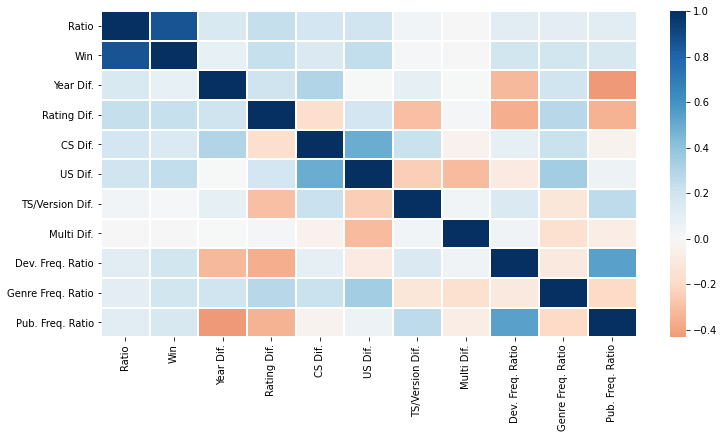

In [14]:
#相关度矩阵
plt.figure(figsize=(12, 6))
sns.heatmap(df_matches.corr(),cmap='RdBu',center = 0.,linewidths=1);

In [15]:
X=df_matches.drop(['Game', 'Opponent', 'Ratio', 'Win'], axis=1)
y=df_matches['Win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 80)

In [16]:
best_penalty=''
best_C=0
best_solver=''
best_score=0
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
for u in range(1,101):
    for j in ['l1','l2']:
        for k2 in ['liblinear','lbfgs','newton-cg','sag']:
          try:
            u2=u*0.01
            from sklearn.linear_model import LogisticRegression
            classifer=LogisticRegression(C=u2,penalty=j,solver=k2)
            classifer=classifer.fit(X_train,y_train)
            score=classifer.score(X_test,y_test)
            if best_score<score:
                                best_score=score
                                best_penalty=j
                                best_solver=k2
                                best_C=u2
          except:
            pass
print("最好模型如下：")
print(best_score,best_penalty,best_solver,best_C)

最好模型如下：
0.7368421052631579 l2 liblinear 0.01


In [17]:
LRC=LogisticRegression(C=best_C,penalty=best_penalty,solver=best_solver)
y_pred=LRC.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.83      0.77      0.80        13

    accuracy                           0.74        19
   macro avg       0.70      0.72      0.71        19
weighted avg       0.75      0.74      0.74        19

[[ 4  2]
 [ 3 10]]
